# Final work

<b> Что нужно сделать </b> 

1. Проведите подготовительную работу (один час):
* Прочитайте предоставленный датасет.
* Ознакомьтесь с описаниями представленных атрибутов.
* Оцените полноту и чистоту данных. Попытайтесь понять, что стоит за этими данными в реальном мире. Приведите данные в удобный/нормальный вид для дальнейшей работы. 

2. Проведите разведочный анализ данных (четыре часа):
* Проведите базовую чистку: дубликаты, пустые значения, типизация данных, ненужные атрибуты.
* Посмотрите на распределение ключевых атрибутов, их отношения.

3. Выполните задание согласно вашей специализации (18 часов):
* Научитесь предсказывать совершение целевого действия (ориентировочное значение ROC-AUC ~ 0.65) — факт совершения пользователем целевого действия.
* Упакуйте получившуюся модель в сервис, который будет брать на вход все атрибуты, типа utm_*, device_*, geo_*, и отдавать на выход 0/1 (1 — если пользователь совершит любое целевое действие).

In [ ]:
# !pip install missingno

In [1]:
# !pip install geopy

In [1]:
import pandas as pd
import pickle
import missingno as msno
import matplotlib.pyplot as plt 

In [2]:
from scipy import stats
import geopy
from geopy.geocoders import Nominatim

In [3]:
import numpy as np

In [4]:
RS = 42

# EDA

## Load data and view

In [5]:
# Загрузка данных по сессиям
with open('data/ga_sessions.pkl', 'rb') as file:
    sessions = pickle.load(file)

In [6]:
sessions

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,VlqBmecIOXWjCWUmQkLd,desktop,Windows,None,NaN,1920x1080,Chrome,Russia,Moscow
1860038,9055421130527858185.1622007305.1622007305,2108379530.1622007305,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,None,Apple,NaN,390x844,Safari,Russia,Stavropol
1860039,9055422955903931195.1636979515.1636979515,2108379955.1636979515,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,375x667,Safari,Russia,Moscow
1860040,905543020766873816.1638189404.1638189404,210838164.1638189272,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,NaN,393x851,Chrome,Russia,Chelyabinsk


In [7]:
sessions.columns

Index(['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number',
       'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_model', 'device_screen_resolution', 'device_browser',
       'geo_country', 'geo_city'],
      dtype='object')

<Axes: >

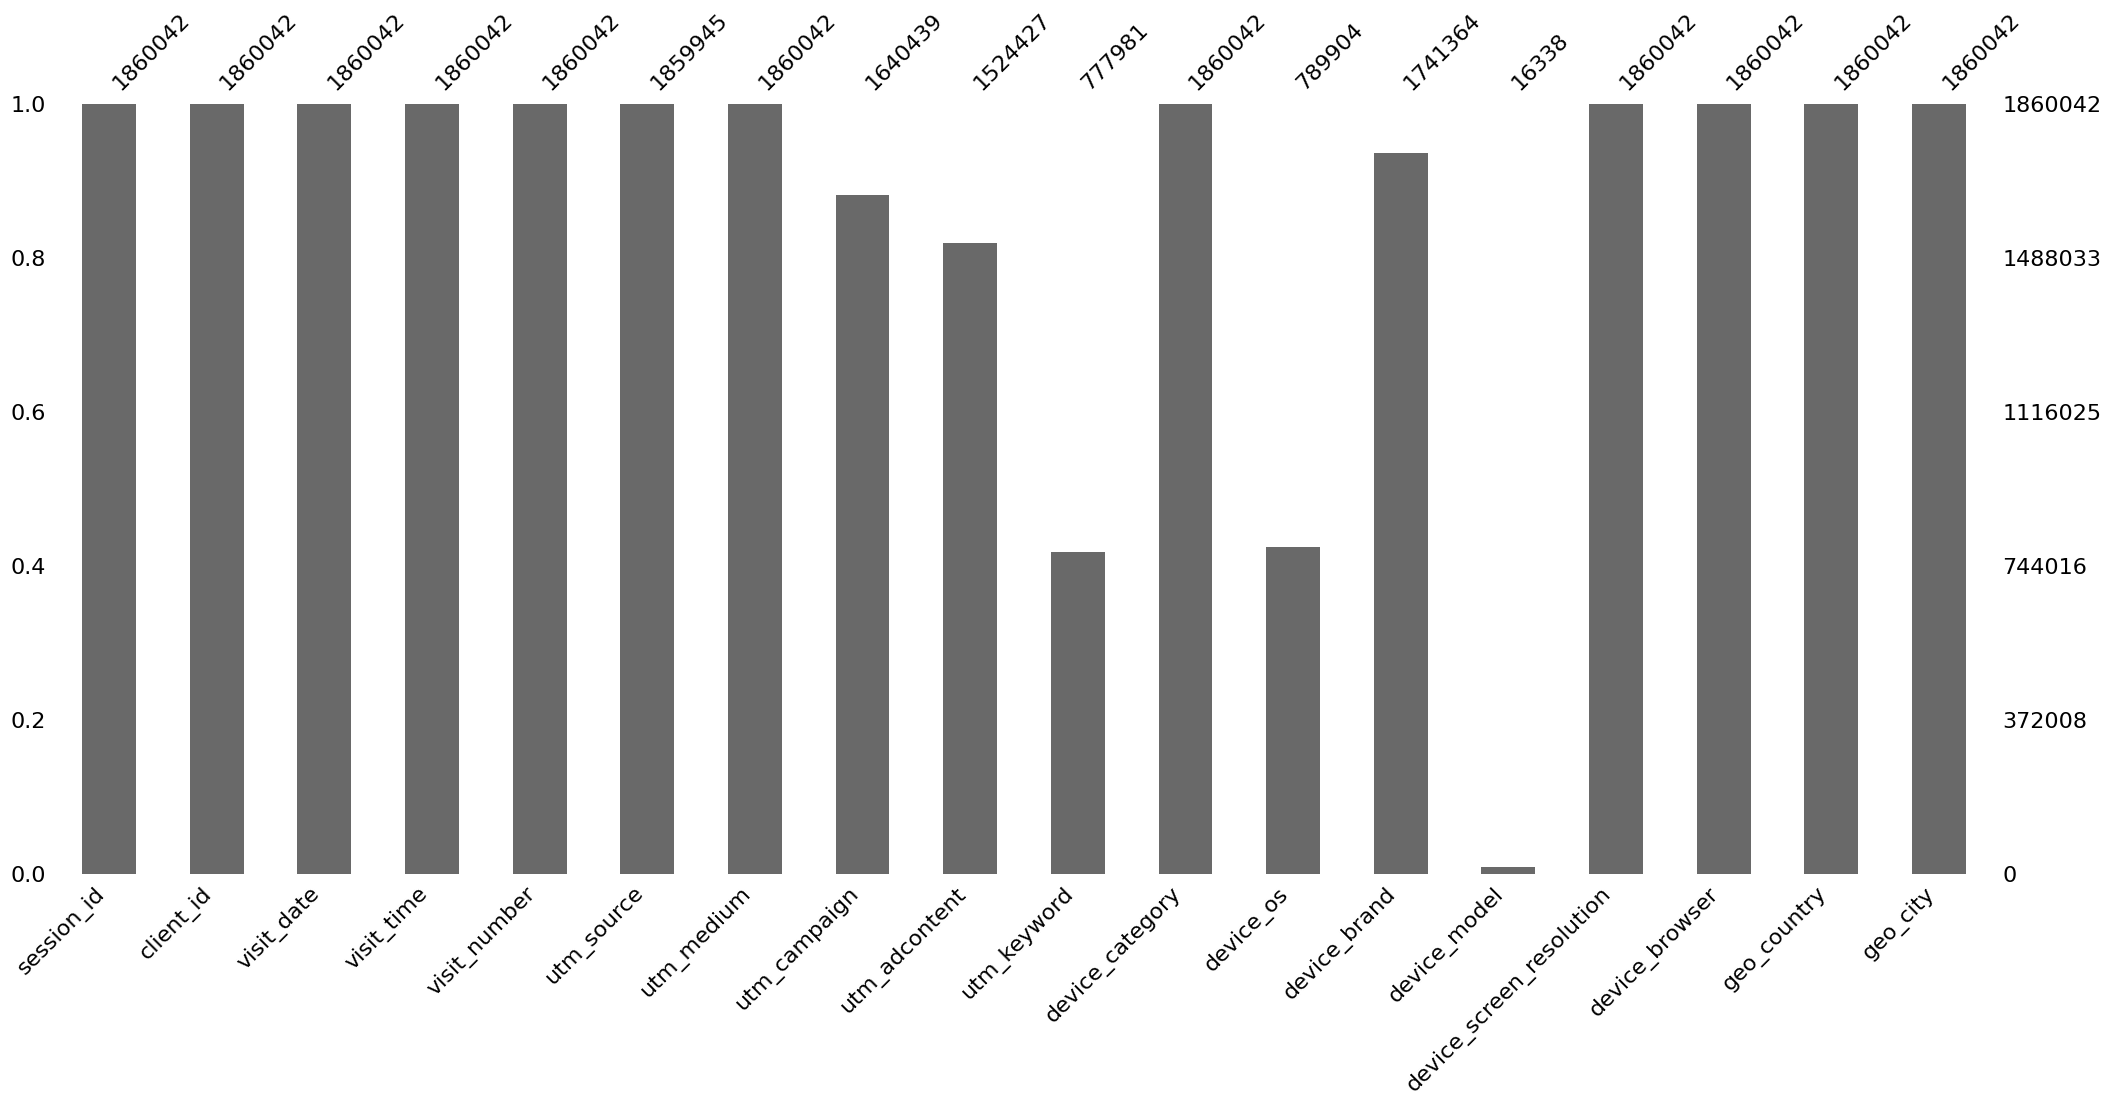

In [8]:
# Смотрим заполненность полей
msno.bar(sessions)

In [9]:
# Смотрим дубликаты в начале
sessions.duplicated().sum()

0

In [10]:
# Выбираем фичи для дальнейшей работы
feature_list = ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_model', 'device_screen_resolution', 'device_browser',
       'geo_country', 'geo_city']

In [11]:
# В разрезе рассматриваемых фич дубликатов предостаточно
sessions[feature_list].duplicated().sum()

1443220

In [12]:
# Загрузка данных по действиям для выделения целевой переменной
with open('data/ga_hits.pkl', 'rb') as file:
    ga_hits = pickle.load(file)

In [13]:
ga_hits

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,None
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,None
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,None
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,None
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...
15726465,6866159858916559617.1640270865.1640270865,2021-12-23,810589.0,43,event,NaN,sberauto.com/cars/all/toyota/fortuner/24cb5af2...,quiz,quiz_show,NaN,None
15726466,7310304587364460692.1640261783.1640261783,2021-12-23,904927.0,40,event,NaN,sberauto.com/cars/all/mercedes-benz/gla-klasse...,quiz,quiz_show,NaN,None
15726467,8013702685784312179.1640270195.1640270195,2021-12-23,2172865.0,43,event,NaN,sberauto.com/cars/all/toyota/alphard/2ebe4871?...,quiz,quiz_show,NaN,None
15726468,8021505554734405918.1640257821.1640257821,2021-12-23,713325.0,45,event,NaN,sberauto.com/cars/all/bmw/x3/6a660f0a?rental_p...,quiz,quiz_show,NaN,None


In [14]:
ga_hits.columns

Index(['session_id', 'hit_date', 'hit_time', 'hit_number', 'hit_type',
       'hit_referer', 'hit_page_path', 'event_category', 'event_action',
       'event_label', 'event_value'],
      dtype='object')

<Axes: >

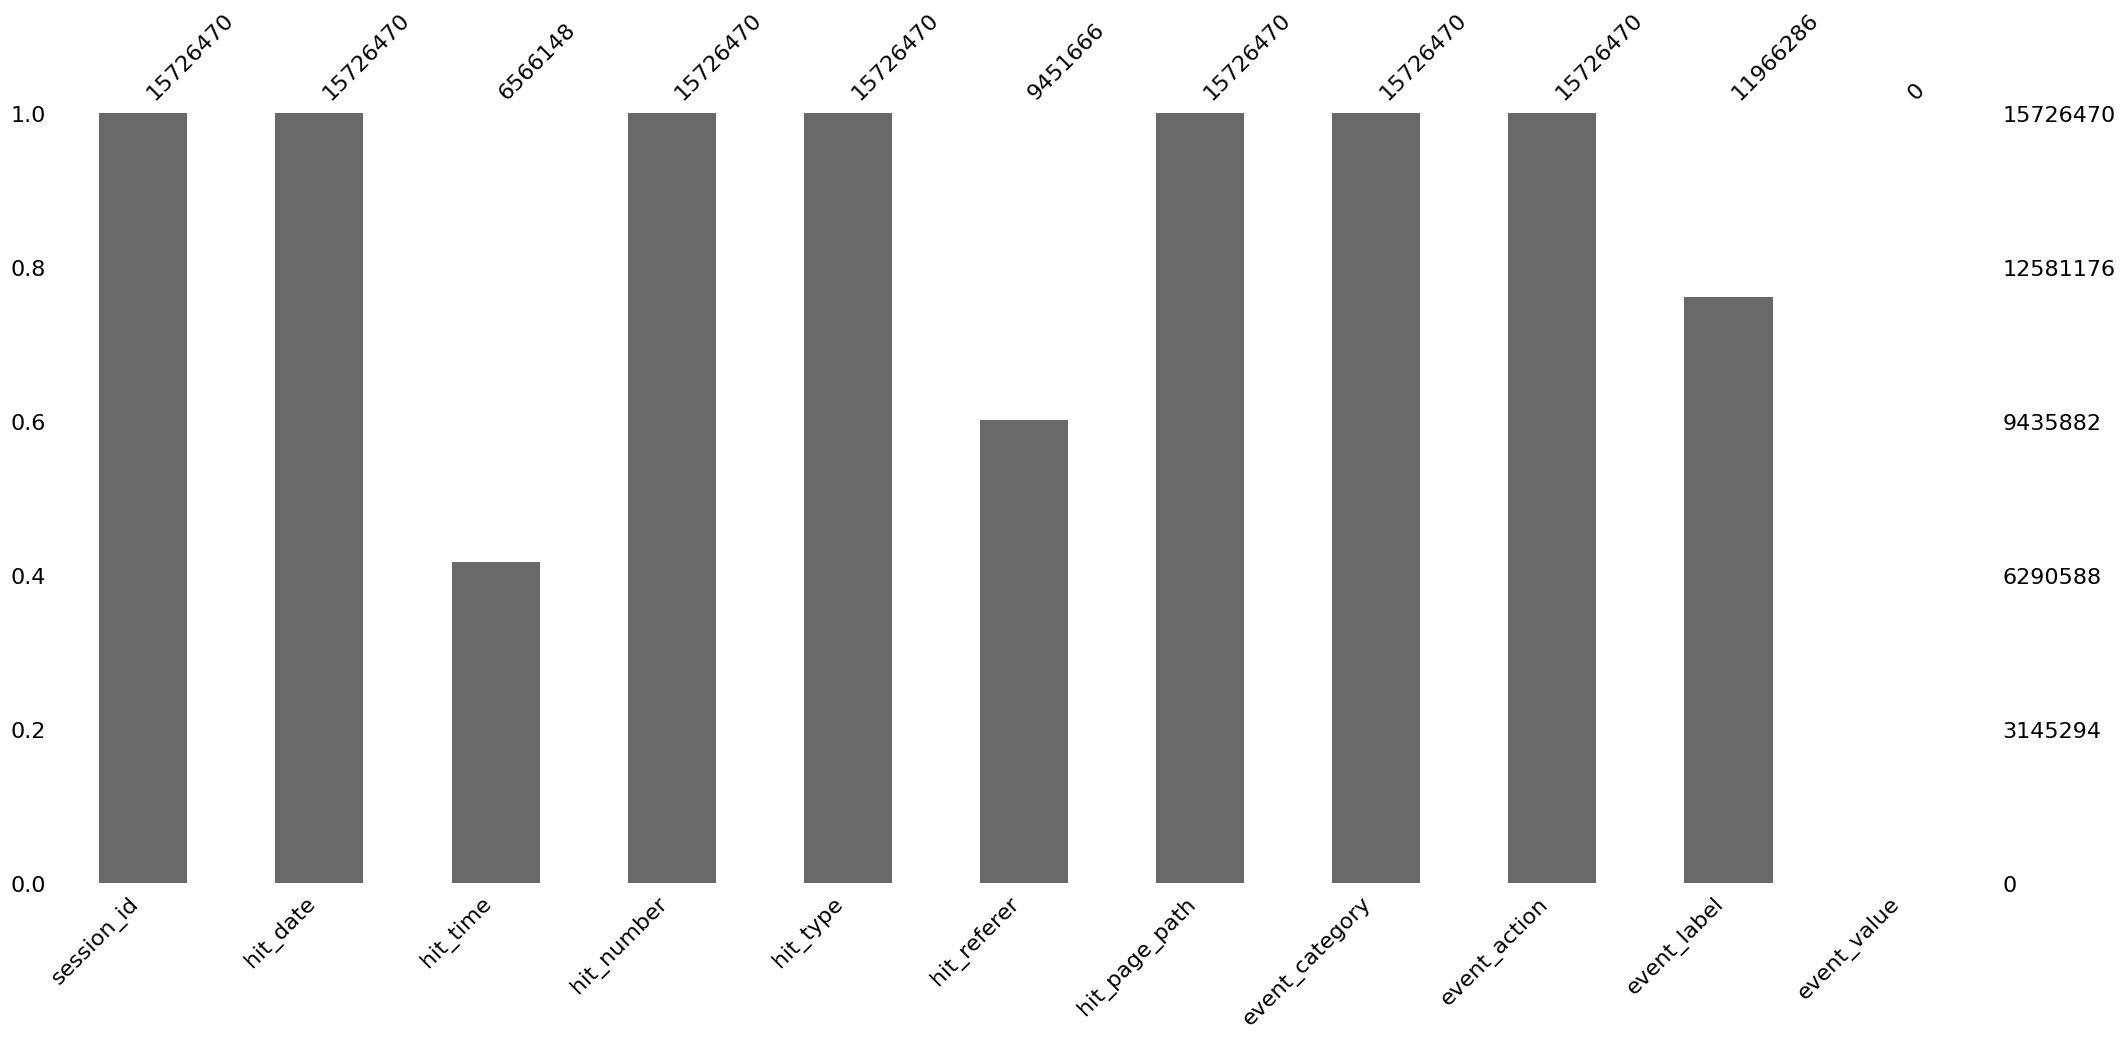

In [15]:
# Смотрим заполненность данных (интересно же)
msno.bar(ga_hits)

In [16]:
# Смотрим дубликаты
ga_hits.duplicated().sum()

0

Согласно условию задания сервис должен принимать "на вход все атрибуты, типа utm_*, device_*, geo_* ". Поэтому из таблицы ga_hits буду использовать только значения целевой переменной. 

Целевое действие — события типа «Оставить заявку» и «Заказать звонок»
(ga_hits.event_action in ['sub_car_claim_click', 'sub_car_claim_submit_click',
'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click']).

In [17]:
cr_list = ['sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click', 
 'sub_custom_question_submit_click', 'sub_call_number_click', 'sub_callback_submit_click', 
 'sub_submit_success', 'sub_car_request_submit_click']

In [18]:
ga_hits['conversion'] = ga_hits.event_action.apply(lambda x: x in cr_list)

In [19]:
ga_hits['conversion'].value_counts()

conversion
False    15621562
True       104908
Name: count, dtype: int64

In [20]:
ga_hits['conversion'].sum()/ga_hits['conversion'].shape[0]

0.006670791347327149

In [21]:
%%time
data = ga_hits.groupby(['session_id']).agg({'conversion': 'max'})
data

CPU times: total: 12 s
Wall time: 25.4 s


,conversion
session_id,
1000009318903347362.1632663668.1632663668,False
1000010177899156286.1635013443.1635013443,False
1000013386240115915.1635402956.1635402956,False
1000017303238376207.1623489300.1623489300,False
1000020580299877109.1624943350.1624943350,False
...,...
999960188766601545.1626816843.1626816843,False
99996598443387715.1626811203.1626811203,False
999966717128502952.1638428330.1638428330,False


In [22]:
sessions = sessions.merge(data, on='session_id', how='inner')

<Axes: >

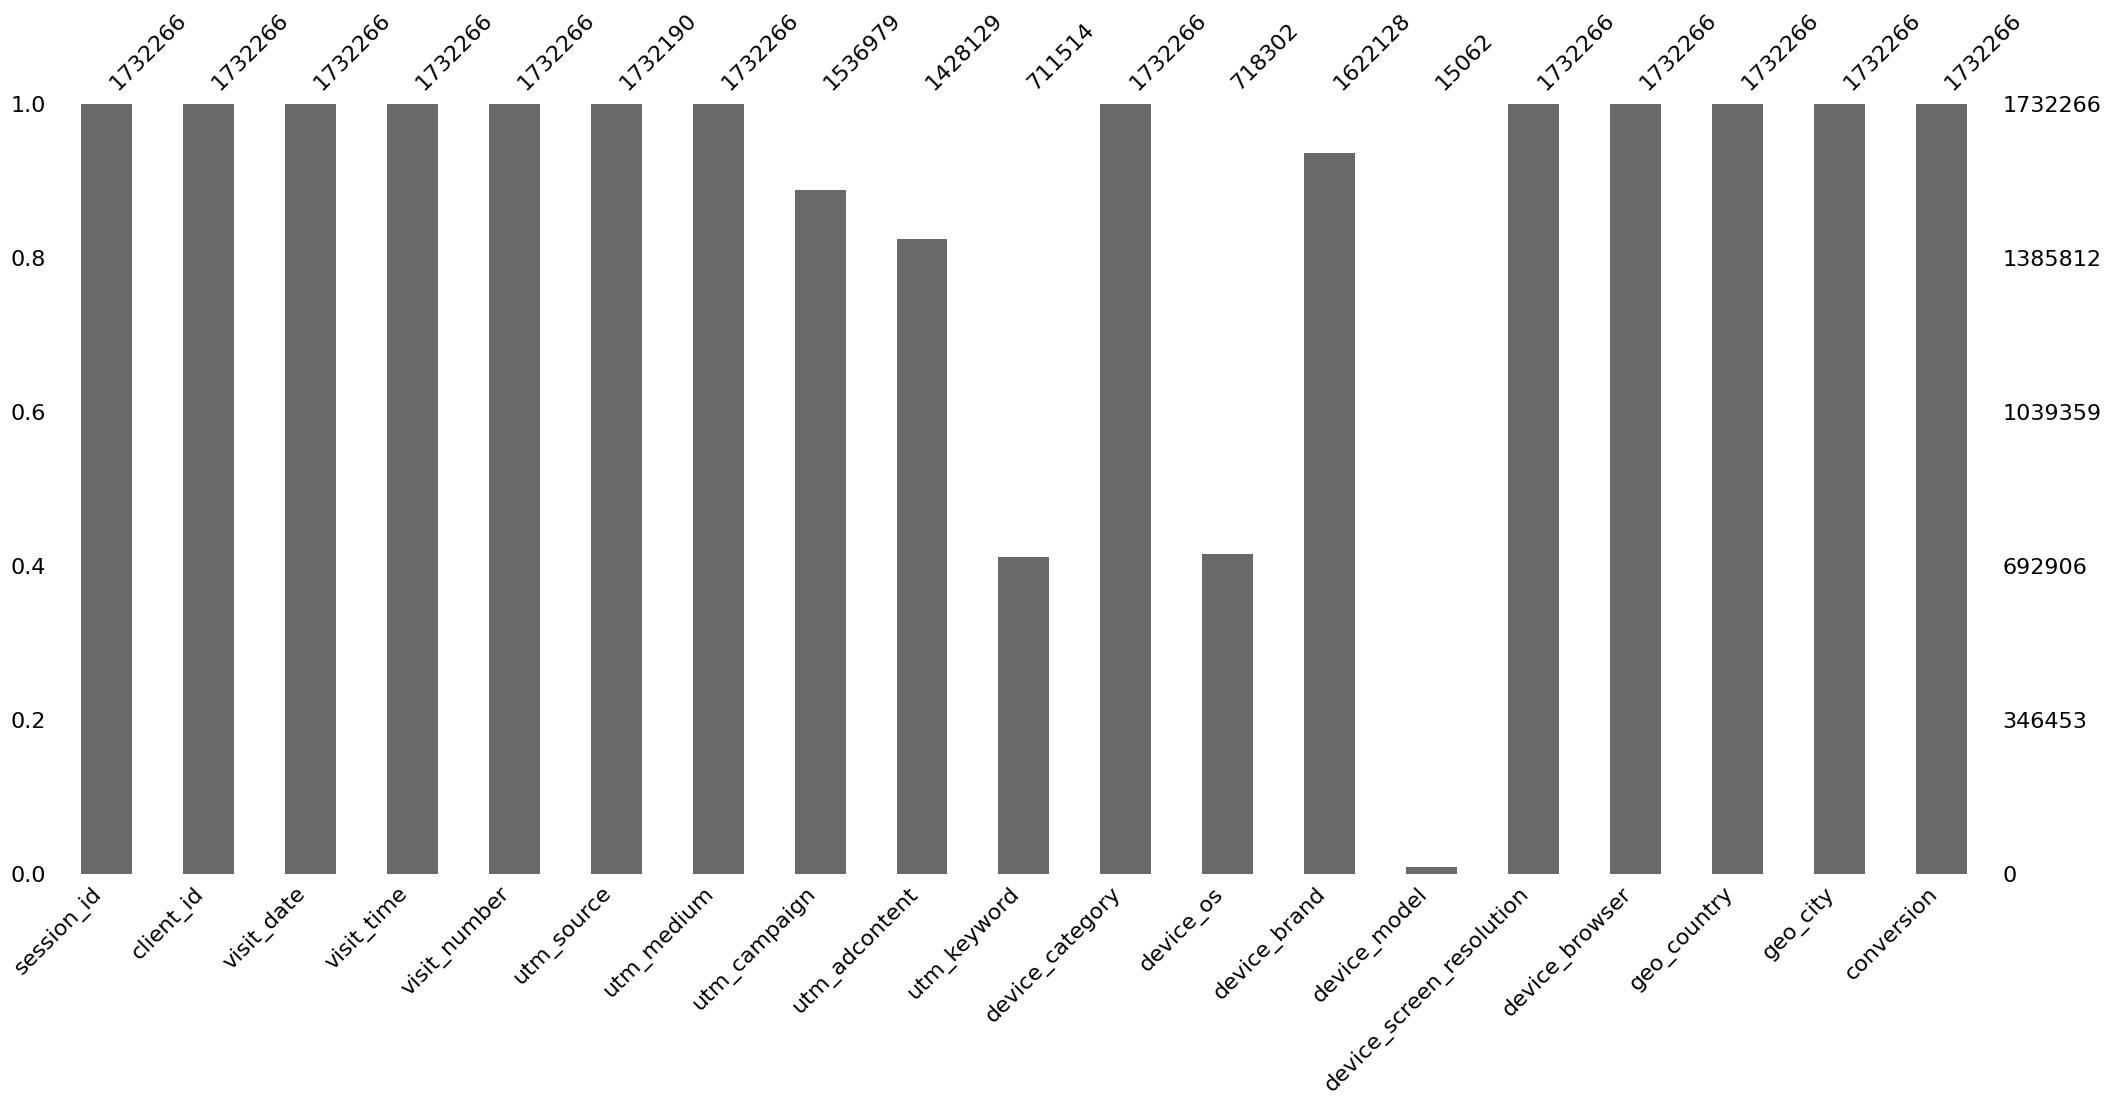

In [23]:
msno.bar(sessions)

In [24]:
sessions.conversion.value_counts()

conversion
False    1681952
True       50314
Name: count, dtype: int64

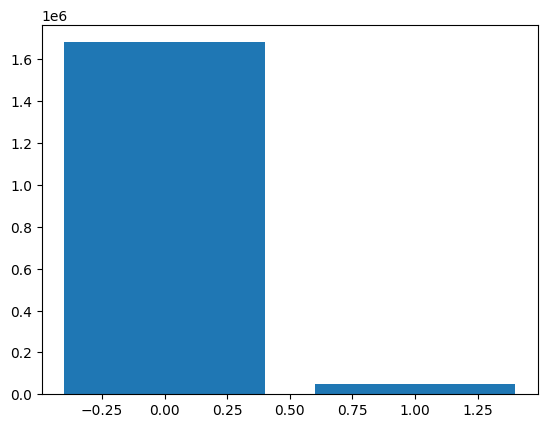

In [25]:
# Разница в объеме классов огромная...
plt.bar([0, 1], sessions.conversion.value_counts())
plt.show()

In [26]:
sessions['target'] = sessions.conversion.apply(lambda x: int(x))

In [27]:
sessions.duplicated().sum()

0

In [28]:
# Формируем таблицу для дальнейшего анализа
use_list = feature_list.copy()

use_list.append('target')
use_list

['utm_source',
 'utm_medium',
 'utm_campaign',
 'utm_adcontent',
 'utm_keyword',
 'device_category',
 'device_os',
 'device_brand',
 'device_model',
 'device_screen_resolution',
 'device_browser',
 'geo_country',
 'geo_city',
 'target']

In [29]:
# Смотрим и удаляем дубликаты
sessions[use_list].duplicated().sum()

1319574

In [30]:
sessions = sessions[use_list].drop_duplicates()

In [31]:
sessions[use_list].duplicated().sum()

0

In [32]:
sessions.target.value_counts()

target
0    388251
1     24441
Name: count, dtype: int64

## Анализ колонок

In [33]:
sessions.columns

Index(['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_model', 'device_screen_resolution', 'device_browser',
       'geo_country', 'geo_city', 'target'],
      dtype='object')

In [34]:
# функция для обобщения признаков без целевого действия
def decrease_unconv(in_series, target_series):
    series = in_series.fillna('other')
    on_conv_set = set(series[target_series==1].to_list())
    return series.apply(lambda x: x if x in on_conv_set else 'out')


In [35]:
# функция для объединения редких категорий в одну
def category_increase_by_bound(data_series, bound=30):
    values_dic = {}
    for v, c in zip(data_series.value_counts().index, data_series.value_counts()):
        values_dic[v] = c
    return data_series.apply(lambda x: x if values_dic[x] > bound else 'bounded' )

### 'utm_source' — канал привлечения

Реклама в социальных сетях — все визиты с ga_sessions.utm_source in
('QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs', 'IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw',
'gVRrcxiDQubJiljoTbGm').

Рассматривал разные варианты работы с фичами. Некоторые подходы оставил как комментарии

In [36]:
sessions.utm_source.value_counts(dropna=False)

utm_source
ZpYIoDJMcFzVoPFsHGJL    94757
kjsLglQLzykiRbcDiGcD    69171
MvfHsxITijuriZxsqZqt    50438
fDLlAcSmythWSCVMvqvL    41247
bByPQxmDaMXgpHeypKSM    33735
                        ...  
VdeFdoGCqZBxFfKSHNLl        1
DBLWVjTjVZuzWYWTaDfZ        1
DWvtKQncdpXXfLBjBmGj        1
ZsHOHNXkbhgIDlKNiFMf        1
ShCnUddaAbEvEVCCZyOt        1
Name: count, Length: 281, dtype: int64

In [37]:
sessions.utm_source.isna().sum()

39

In [38]:
sessions.utm_source = sessions.utm_source.fillna('other')

In [39]:
# Делаем признак канала привлечения только как "Реклама в социальных сетях"

sessions.utm_source = sessions.utm_source.apply(lambda x: 1 if x in ('QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs', 'IZEXUFLARCUMynmHNBGo', 
                        'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm') else 0)

In [40]:
# category_increase_by_bound('utm_source', bound=100)

# decrease_unconv('utm_source')

# # Заполним пустые значения
# columns_to_fill_other.append('utm_source')

# sessions[columns_to_fill_other[5]] = sessions[columns_to_fill_other[5]].fillna('other')

In [41]:
sessions.utm_source.value_counts()

utm_source
0    338881
1     73811
Name: count, dtype: int64

In [42]:
sessions.utm_source.isna().sum()

0

### 'utm_medium' —  тип привлечения

In [43]:
sessions.utm_medium.value_counts()

utm_medium
cpc                  120077
banner                92934
cpm                   61900
referral              48203
(none)                41247
organic               12834
email                 10051
blogger_channel        4701
push                   4172
stories                3716
blogger_stories        2194
cpv                    2056
smartbanner            1782
tg                     1655
cpa                    1238
post                    710
smm                     521
blogger_header          520
outlook                 490
app                     457
clicks                  440
(not set)               233
info_text               164
sms                     116
partner                  74
landing                  36
vk_smm                   22
yandex_cpc               21
cbaafe                   21
static                   16
link                     12
google_cpc               10
article                  10
web_polka                 8
fb_smm                    8
CPM      

In [44]:
sessions.utm_medium.isna().sum()

0

In [45]:
# Тим привлечения делаем как "Органический трафик"

sessions.utm_medium = sessions.utm_medium.apply(lambda x: 1 if x in ('organic', 'referral', '(none)') else 0)

In [46]:
# # category_increase_by_bound('utm_medium', bound=300)
# decrease_unconv('utm_medium')

In [47]:
sessions.utm_medium.value_counts()

utm_medium
0    310408
1    102284
Name: count, dtype: int64

### 'utm_campaign' — рекламная кампания

In [48]:
sessions.utm_campaign.value_counts(dropna=False)

utm_campaign
LTuZkdKfxRGVceoWkVyg    82693
FTjNLDyTrXaWYgZymFkV    64235
LEoPHuyFvzoNfnzGgfcd    46131
NaN                     44520
gecBYcKZCPMcVYdSSzKP    24838
                        ...  
cqgnjDbqrtCipVvzhxqa        1
AdtHYglxfCpTpwZeTAuW        1
eYRDXZIocNyHVjEHzesr        1
qPDTdivQVeflLjTYIJnG        1
cXxuwXPoQCvAXPHpFcZl        1
Name: count, Length: 407, dtype: int64

In [49]:
sessions.utm_campaign.isna().sum()

44520

In [50]:
sessions.utm_campaign = decrease_unconv(sessions.utm_campaign, sessions.target)

In [51]:
sessions.utm_campaign = category_increase_by_bound(sessions.utm_campaign, bound=30)

In [52]:
sessions.utm_campaign.value_counts()

utm_campaign
LTuZkdKfxRGVceoWkVyg    82693
FTjNLDyTrXaWYgZymFkV    64235
LEoPHuyFvzoNfnzGgfcd    46131
other                   44520
gecBYcKZCPMcVYdSSzKP    24838
                        ...  
vsIeXLhfMWBRXWnTmgPr       39
KyobiyHqbFtWswycTXJo       39
KCcrgoFqYxCpSjdRyJjZ       37
qQToznZzQEwXqmrMVfCd       36
zBKTCFUiXurMYBESygaA       33
Name: count, Length: 195, dtype: int64

In [53]:
# sessions.utm_campaign = non_zero_user_transform('utm_campaign')

In [54]:
# decrease_unconv('utm_campaign')

In [55]:
# category_increase_by_bound('utm_campaign', bound=200)

In [56]:
# # Заполним пустые значения
# columns_to_fill_other.append('utm_campaign')

# sessions[columns_to_fill_other[4]] = sessions[columns_to_fill_other[4]].fillna('other')

In [57]:
sessions.utm_campaign.isna().sum()

0

### 'utm_adcontent' 

In [58]:
sessions.utm_adcontent.value_counts()

utm_adcontent
JNHcPlZPxEMWDnRiyoBf    213669
xhoenQgDQsgfEPYNPwKO     35541
vCIpmpaGBnIQhyYNkXqp     23149
PkybGvWbaqORmxjNunqZ     10548
LLfCasrxQzJIyuldcuWy      4418
                         ...  
cnqeKMAxlNzlImHJTOns         1
fiImkyBmzQSeAeQEVCDZ         1
uUDFLZnWKzkthhRGUTvb         1
vXARZToVDdvNhALiQtvl         1
oJivRDNIrrOckRBIKOtG         1
Name: count, Length: 280, dtype: int64

In [59]:
# sessions.utm_adcontent = non_zero_user_transform('utm_adcontent')
sessions.utm_adcontent = decrease_unconv(sessions.utm_adcontent, sessions.target)

In [60]:
sessions.utm_adcontent = category_increase_by_bound(sessions.utm_adcontent, bound=30)

In [61]:
sessions.utm_adcontent.value_counts()

utm_adcontent
JNHcPlZPxEMWDnRiyoBf    213669
other                    78796
xhoenQgDQsgfEPYNPwKO     35541
vCIpmpaGBnIQhyYNkXqp     23149
PkybGvWbaqORmxjNunqZ     10548
                         ...  
hrqYkXkJsxqBbbPugYJm        51
ePOwRDMsDnhYErGgxfUz        48
LneEZMBzQifgNGkbGWMt        40
QXCBxPuOCSEEHrqrweFV        37
ZbhjTfTaZOUpHAHHpvsP        36
Name: count, Length: 82, dtype: int64

In [62]:
# decrease_unconv('utm_adcontent')

# category_increase_by_bound('utm_adcontent', bound=100)

# sessions.utm_adcontent.value_counts()

# # Заполним пустые значения
# columns_to_fill_other.append('utm_adcontent')

# sessions[columns_to_fill_other[3]] = sessions[columns_to_fill_other[3]].fillna('other')

In [63]:
sessions.utm_adcontent.isna().sum()

0

### utm_keyword — ключевое слово

In [64]:
sessions.utm_keyword.value_counts(dropna=False)

utm_keyword
NaN                     210545
puhZPIYqKXeFPaUviSjo    105967
aXQzDWsJuGXeBXexNHjc      4425
ITfrGJNwVsHBGJMAKoct      3415
UKNBOHebRIIsQRsjNKay      3097
                         ...  
sLQbYFRIWJPmCqXsQgTS         1
iNaIAFVuZgYukekFQQbX         1
jiuZfEGBRodFnHKeFJbS         1
cqgnjDbqrtCipVvzhxqa         1
fcXWTQaKfxbkBkBnzLhK         1
Name: count, Length: 1193, dtype: int64

In [65]:
sessions.utm_keyword = decrease_unconv(sessions.utm_keyword, sessions.target)

In [66]:
sessions.utm_keyword = category_increase_by_bound(sessions.utm_keyword, bound=30)

In [67]:
sessions.utm_keyword.value_counts(dropna=False)

utm_keyword
other                   210545
puhZPIYqKXeFPaUviSjo    105967
out                      10813
aXQzDWsJuGXeBXexNHjc      4425
ITfrGJNwVsHBGJMAKoct      3415
                         ...  
yOYvEgEDzVUVhcnFuivG        32
gfRXeeTqICtnANYqYjnS        32
rmVZWYFMcnGputYDEnAW        32
KXRJMPPRGoMIgkFfvZpk        32
ZiHEFAowQMBIYnNddrMG        31
Name: count, Length: 265, dtype: int64

In [68]:
# decrease_unconv('utm_keyword')

In [69]:
sessions.utm_keyword.isna().sum()

0

### device_category — тип устройства

In [70]:
# Категорий не много, можно без преобразований фич
sessions.device_category.value_counts(dropna=False)

device_category
mobile     312362
desktop     89819
tablet      10511
Name: count, dtype: int64

In [72]:
sessions[['device_category', 'target']].value_counts()

device_category  target
mobile           0         293745
desktop          0          84364
mobile           1          18617
tablet           0          10142
desktop          1           5455
tablet           1            369
Name: count, dtype: int64

In [73]:
# mobile           0         
18617/(18617+293745)

0.05960071967780972

In [74]:
# desktop          0          
5455/(5455+84364)

0.060733252429886773

In [75]:
# tablet           0          
369/(369+10142)       

0.03510607934544763

In [76]:
sessions.device_category.isna().sum()

0

In [77]:
# Для интереса. конверсия по мобильному и компу примерно одинаковая, по планшету ниже 

### device_os — ОС устройства

In [78]:
sessions.device_os.value_counts(dropna=False)

device_os
None             208165
Android          132107
iOS               32180
Windows           28681
Macintosh          9221
Linux              2194
(not set)            60
Chrome OS            51
BlackBerry           18
Tizen                 7
Firefox OS            2
Nokia                 2
Samsung               2
Windows Phone         2
Name: count, dtype: int64

In [79]:
# Заполним пустые значения значением other
columns_to_fill_other = ['device_os']
sessions[columns_to_fill_other[0]] = sessions[columns_to_fill_other[0]].fillna('other')


In [80]:
sessions.device_os.value_counts(dropna=False)

device_os
other            208165
Android          132107
iOS               32180
Windows           28681
Macintosh          9221
Linux              2194
(not set)            60
Chrome OS            51
BlackBerry           18
Tizen                 7
Firefox OS            2
Nokia                 2
Samsung               2
Windows Phone         2
Name: count, dtype: int64

In [81]:
sessions.device_os.isna().sum()

0

### device_brand — марка устройства

In [82]:
sessions.device_brand.value_counts(dropna=False)

device_brand
Samsung     81400
Apple       67657
Xiaomi      56959
            49799
Huawei      47016
            ...  
Jiayu           1
Tesla           1
Vodafone        1
Wexler          1
Maxvi           1
Name: count, Length: 202, dtype: int64

In [83]:
# sessions[sessions.device_brand.isna()].conversion.sum()

# sessions[sessions.device_brand.notna()].conversion.sum()

# sessions.device_brand.isna().sum()

# sessions[sessions.device_brand.isna()].conversion.sum()/sessions.device_brand.isna().sum()

# sessions[sessions.device_brand.notna()].conversion.sum()/sessions.device_brand.notna().sum()

# sessions[sessions.device_brand.isna()].conversion.sum()/sessions[sessions.device_brand.notna()].conversion.sum()

Отношение конверсии по незаполненным значениям поля device_brand значительно отличается от всего датасета. Пустые значения нужно заполнять. Заполним значением other.

In [84]:
# sessions['device_brand'] = sessions.device_brand.fillna('other')

In [85]:
sessions.device_brand = decrease_unconv(sessions.device_brand, sessions.target)

In [86]:
sessions.device_brand = category_increase_by_bound(sessions.device_brand, bound=30)

In [87]:
sessions.device_brand.value_counts()

device_brand
Samsung       81400
Apple         67657
Xiaomi        56959
              49799
Huawei        47016
other         40202
(not set)      9769
Realme         5942
Vivo           5512
OPPO           5077
OnePlus        5019
Nokia          4603
Asus           4240
ZTE            3464
Sony           3266
Google         2589
Lenovo         2201
Meizu          2186
Blackview      1685
Motorola       1550
LG             1452
Tecno          1365
BQ             1154
out             761
itel            692
DOOGEE          690
Oukitel         632
Alcatel         610
HTC             503
Umidigi         476
Ulefone         366
Vsmart          287
Infinix         275
Cubot           273
Philips         246
LeEco           235
Mozilla         200
BlackBerry      182
Sharp           172
DEXP            161
bounded         160
TP-Link         156
Vertex          156
POCO            146
Prestigio       137
Leagoo          136
Micromax        120
Wileyfox        119
Neffos          113
Inoi   

In [88]:
sessions.device_brand.isna().sum()

0

### device_model — модель устройства

In [89]:
# Самая пустая колонка
sessions.device_model.value_counts(dropna=False)

device_model
NaN                     403192
AuMdmADEIoPXiWpTsBEj      5257
tWBQlsvNfHxRUjaPAfhd       321
cwMJxNXiWUgMUxGiCTPs       302
pTgAEPipQxDXCjPrJbHo       258
                         ...  
XnjPzKjkHmznVfULanbE         1
hOhIHYHnDhUlkzDoZJdA         1
zcovoWIWBZLooJXEJyTD         1
TMDlgkQzhHCgECHRtiOW         1
UBWdrePiTaaBAMHVHpOq         1
Name: count, Length: 105, dtype: int64

In [90]:
# sessions[sessions.device_model.isna()]['conversion'].sum()

# sessions[sessions.device_model.notna()]['conversion'].sum()

# sessions[sessions.device_model.notna()]['conversion'].sum()/sessions[sessions.device_model.isna()]['conversion'].sum()

# sessions[sessions.device_model.notna()]['conversion'].sum()/sessions.device_model.notna().sum()

# sessions[sessions.device_model.isna()]['conversion'].sum()/sessions.device_model.isna().sum()

Отношение конверсии не сильно зависит от наличия или отсутствия поля device_model, поэтому буду удалять это поле.

In [91]:
columns_to_drop = ['device_model']

In [92]:
sessions = sessions.drop(columns=columns_to_drop)

### device_screen_resolution — разрешение экрана

In [93]:
sessions.device_screen_resolution.value_counts(dropna=False)

device_screen_resolution
360x640      21155
360x800      20058
360x780      19944
1920x1080    19341
414x896      15651
             ...  
398x842          1
1536x792         1
406x879          1
450x768          1
464x1123         1
Name: count, Length: 4947, dtype: int64

In [94]:
# category_increase_by_bound('device_screen_resolution', bound=500)
# decrease_unconv('device_screen_resolution')
sessions.device_screen_resolution = decrease_unconv(sessions.device_screen_resolution, sessions.target)

In [95]:
sessions.device_screen_resolution = category_increase_by_bound(sessions.device_screen_resolution, bound=30)

In [96]:
sessions.device_screen_resolution.value_counts()

device_screen_resolution
360x640      21155
360x800      20058
360x780      19944
1920x1080    19341
out          16993
             ...  
393x742         32
388x861         32
848x424         31
1088x615        31
463x925         31
Name: count, Length: 307, dtype: int64

In [97]:
sessions.device_screen_resolution.isna().sum()

0

### device_browser — браузер

In [98]:
sessions.device_browser.value_counts(dropna=False)

device_browser
Chrome                              234581
Safari                               58156
YaBrowser                            44570
Android Webview                      22872
Samsung Internet                     15796
Opera                                11421
Safari (in-app)                      10799
Firefox                               7758
Edge                                  5485
UC Browser                             529
Android Runtime                        146
Mozilla Compatible Agent                83
[FBAN                                   73
MRCHROME                                66
Instagram 208.0.0.32.135 Android        40
Puffin                                  38
Android Browser                         35
Instagram 209.0.0.21.119 Android        30
Internet Explorer                       24
Opera Mini                              20
Maxthon                                 19
Android                                 17
Mozilla                                

In [99]:
sessions.device_browser = sessions.device_browser.apply(lambda x: 'Instagram' if x.split(' ')[0]=='Instagram' else x)

In [100]:
# category_increase_by_bound('device_browser', bound=10)
# decrease_unconv('device_browser')
sessions.device_browser = decrease_unconv(sessions.device_browser, sessions.target)

In [101]:
sessions.device_browser.value_counts()

device_browser
Chrome              234581
Safari               58156
YaBrowser            44570
Android Webview      22872
Samsung Internet     15796
Opera                11421
Safari (in-app)      10799
Firefox               7758
Edge                  5485
out                    594
UC Browser             529
MRCHROME                66
Puffin                  38
Maxthon                 19
com.vk.vkclient          8
Name: count, dtype: int64

In [102]:
sessions.device_browser.isna().sum()

0

### geo_country — страна

In [103]:
sessions.geo_country.value_counts(dropna=False)

geo_country
Russia                 380561
Ukraine                  5605
United States            4065
Belarus                  2051
Kazakhstan               1529
                        ...  
New Caledonia               1
Puerto Rico                 1
Yemen                       1
Rwanda                      1
Congo - Brazzaville         1
Name: count, Length: 159, dtype: int64

In [104]:
# sessions[sessions['geo_country']!='Russia'].conversion.sum()

# sessions[sessions['geo_country']=='Russia'].conversion.sum()

# category_increase_by_bound('geo_country', bound=100)
# decrease_unconv('geo_country')

# sessions[sessions['geo_country']=='zero_key'].geo_city.value_counts()

sessions.geo_country = decrease_unconv(sessions.geo_country, sessions.target)

In [105]:
sessions.geo_country = category_increase_by_bound(sessions.geo_country, bound=30)

In [106]:
sessions.geo_country.value_counts()

geo_country
Russia           380561
Ukraine            5605
United States      4065
Belarus            2051
Kazakhstan         1529
                  ...  
Australia            47
Seychelles           44
China                40
Tunisia              37
Slovenia             32
Name: count, Length: 66, dtype: int64

### geo_city — город

In [107]:
sessions.geo_city.value_counts(dropna=False)

geo_city
Moscow              89335
Saint Petersburg    47697
(not set)           20192
Kazan                6542
Yekaterinburg        6504
                    ...  
Hoorn                   1
Schiedam                1
Nimes                   1
Kurakhove               1
Compiegne               1
Name: count, Length: 2389, dtype: int64

#### v1

Попробовал 2 варианта: первый с преобразованием названий городов в их координаты, и второй просто признаки принадлежности к городу. По второму варианту результат оказался лучше.

In [105]:
sity_set = set(sessions.geo_city.value_counts().index)

In [106]:
sity_loc_dic = {}

In [107]:
%%time
locator = Nominatim(user_agent = "myapp")
for i in sity_set:
    sity_loc_dic[i] = locator.geocode(i)

CPU times: total: 9.2 s
Wall time: 19min 58s


In [351]:
sessions.geo_city.isna().sum()

0

In [352]:
temp_loc = sessions.geo_city.apply(lambda x: sity_loc_dic[x])

In [353]:
sessions['lat'] = temp_loc.apply(lambda x: x.latitude if x is not None else 0)

In [354]:
sessions['long'] = temp_loc.apply(lambda x: x.longitude if x is not None else 0)

In [356]:
sessions['lat'].describe()

count    412692.000000
mean         48.023683
std          13.856049
min         -46.411847
25%          44.560945
50%          55.494191
75%          55.750446
max          69.537566
Name: lat, dtype: float64

#### v2

In [108]:
sessions.geo_city = decrease_unconv(sessions.geo_city, sessions.target)

In [109]:
sessions.geo_city.describe()

count     412692
unique       632
top       Moscow
freq       89335
Name: geo_city, dtype: object

In [110]:
sessions.columns

Index(['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_screen_resolution', 'device_browser', 'geo_country', 'geo_city',
       'target'],
      dtype='object')

In [359]:
# V.1
columnst_to_transform = [ 'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_screen_resolution', 'device_browser', 'geo_country']

In [111]:
# V.2
columnst_to_transform = [ 'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_screen_resolution', 'device_browser', 'geo_country', 'geo_city']

In [112]:
# Снова смотрим дубликаты и удаляем
sessions.duplicated().sum()

47637

In [113]:
sessions = sessions.drop_duplicates()

In [114]:
sessions.duplicated().sum()

0

<Axes: >

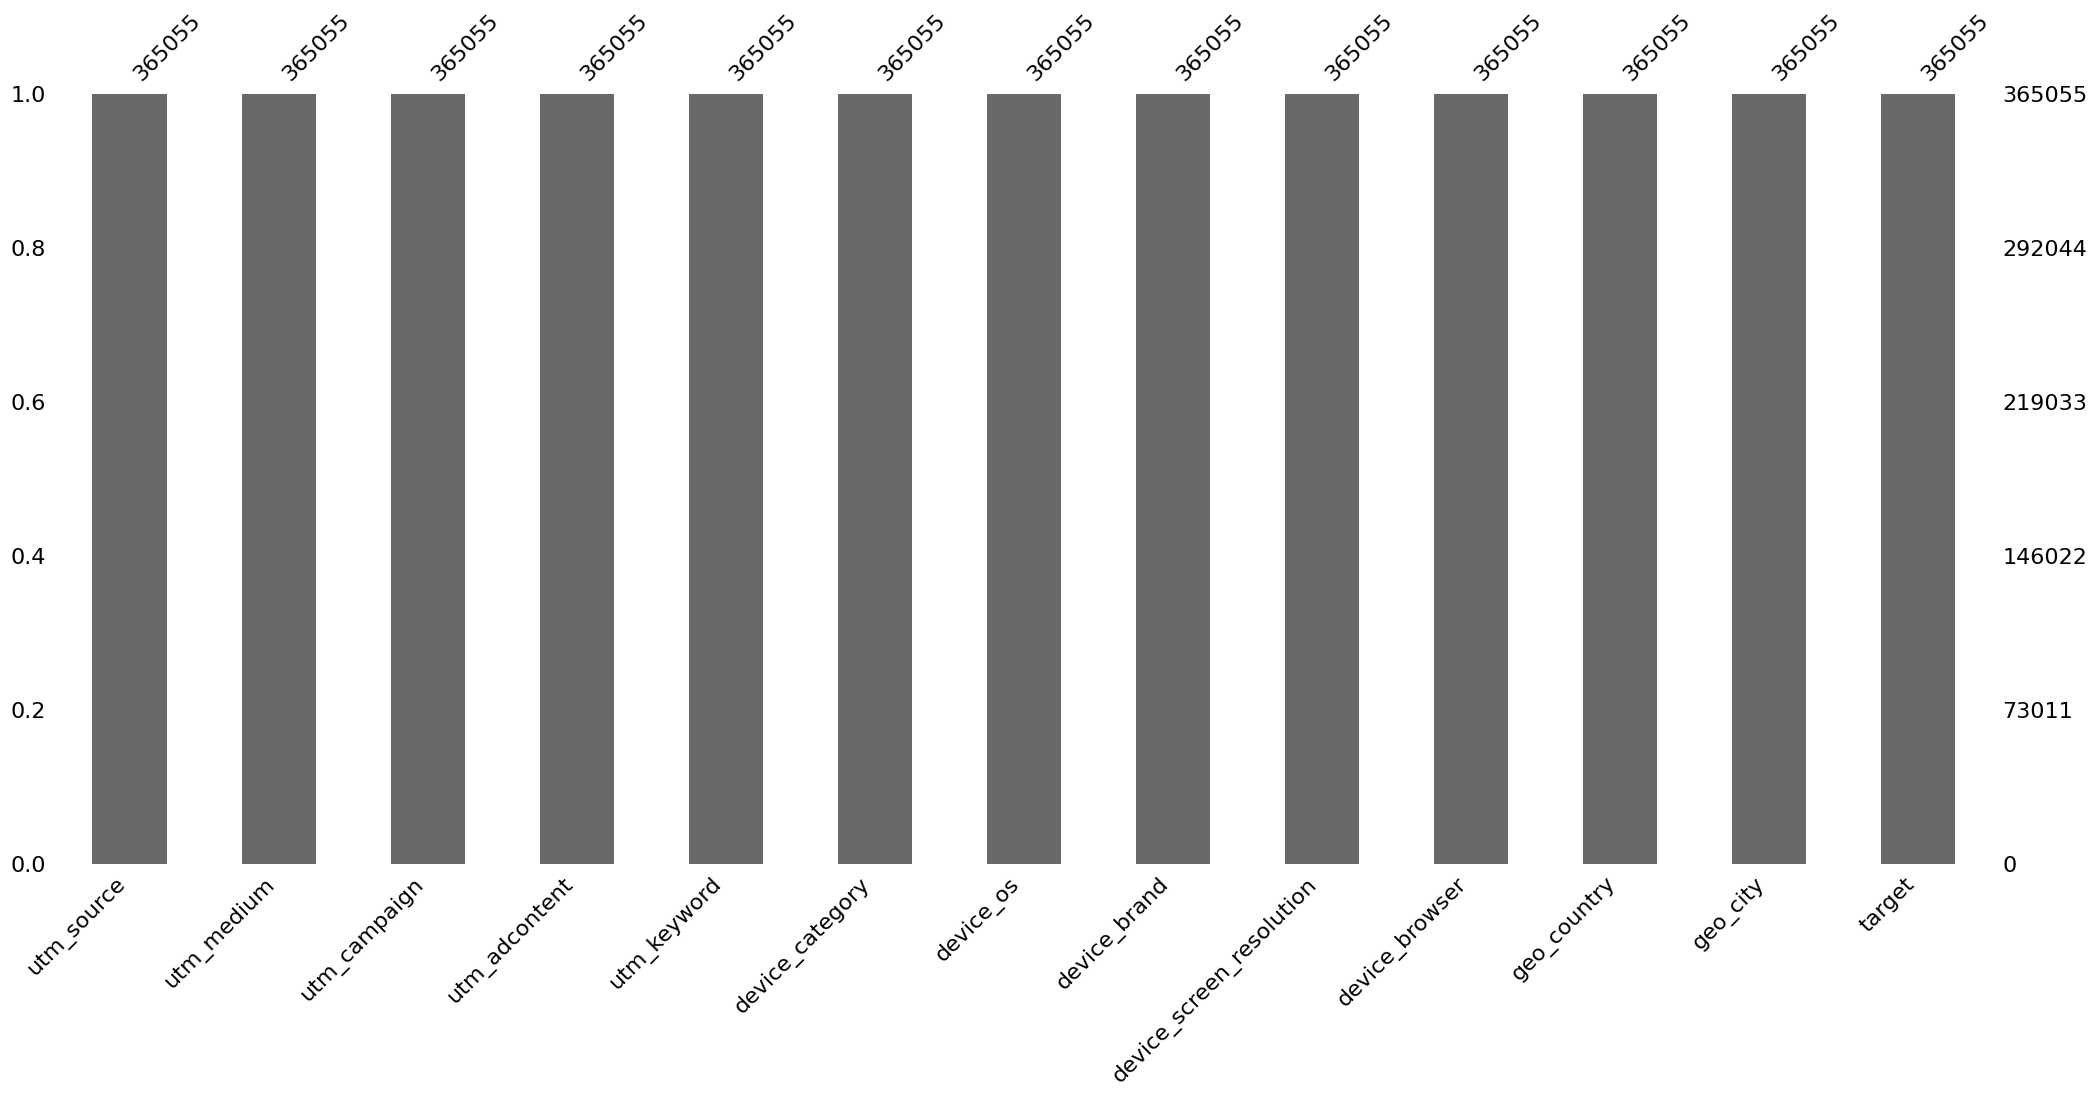

In [115]:
msno.bar(sessions)

In [131]:
sessions.target.value_counts()

target
0    343081
1     21974
Name: count, dtype: int64

Как вариант можно провести балансировку датасета. Пока без балансировки.

## Modelling

In [116]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [117]:
ohe = OneHotEncoder(sparse=False)

In [118]:
columnst_to_transform

['utm_source',
 'utm_medium',
 'utm_campaign',
 'utm_adcontent',
 'utm_keyword',
 'device_category',
 'device_os',
 'device_brand',
 'device_screen_resolution',
 'device_browser',
 'geo_country',
 'geo_city']

In [119]:
ohe.fit(sessions[columnst_to_transform])

D:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(sparse=False, sparse_output=False)

In [120]:
ohe_names = ohe.get_feature_names_out()

In [121]:
ohe_names

array(['utm_source_0', 'utm_source_1', 'utm_medium_0', ...,
       'geo_city_out', 'geo_city_Тимофеевка', 'geo_city_Хомутово'],
      dtype=object)

In [122]:
len(ohe_names)

1642

In [123]:
ohe_data = ohe.transform(sessions[columnst_to_transform])

In [124]:
sessions[ohe_names] = ohe_data

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17980\3332513349.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sessions[ohe_names] = ohe_data


In [125]:
# msno.bar(sessions)

In [126]:
sessions = sessions.drop(columns=columnst_to_transform)

In [127]:
# sessions = sessions.drop(columns='geo_city')  # для версии с трансформацией в координаты

In [128]:
sessions.isna().sum().max()

0

In [129]:
# msno.bar(sessions)

In [187]:
# sessions.columns

In [193]:
# columns_to_drop = ['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number',
#        'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
#        'utm_keyword', 'device_category', 'device_os', 'device_brand',
#        'device_screen_resolution', 'device_browser', 'geo_country', 'geo_city',
#        'conversion']

# ndata = pd.DataFrame()

# ndata[ohe_names] = ohe_data.toarray()

# sessions = sessions.drop(columns=columns_to_drop)

# ndata['lat'] = sessions.lat
# ndata['long'] = sessions.long

# ndata.columns

# names_list = ohe_names.tolist()

# names_list.append('lat')
# names_list.append('long')

In [140]:
# %%time
# sessions.drop_duplicates(inplace=True)

In [194]:
# ndata.shape

In [195]:
# data.shape

In [196]:
# data['target'].value_counts()

In [197]:
# ndata['target'] = sessions.target

### Разбивка датасета

In [130]:
%%time
x_tr, x_test, y_tr, y_test = train_test_split(sessions.drop(columns='target'), sessions['target'], random_state=RS)

CPU times: total: 15.1 s
Wall time: 17.3 s


### Random Forest

In [676]:
rf_clf = RandomForestClassifier(class_weight='balanced',
                           random_state=RS)

In [677]:
%%time
rf_clf.fit(x_tr, y_tr)

CPU times: total: 10min 4s
Wall time: 11min 39s


RandomForestClassifier(class_weight='balanced', random_state=42)

In [678]:
%%time
y_pred = rf_clf.predict(x_test)

CPU times: total: 10.2 s
Wall time: 12.7 s


In [679]:
roc_auc_score(y_test, y_pred)

0.48249933758228697

In [680]:
accuracy_score(y_test, y_pred)

0.9041900420757363

In [681]:
confusion_matrix(y_test, y_pred)

array([[82500,  3319],
       [ 5425,    20]], dtype=int64)

In [682]:
test_proba = rf_clf.predict_proba(x_test)

In [699]:
test_num = list( 1 if x > 0.021 else 0 for x in test_proba[:,1] )

roc_auc_score(y_test, test_num)

0.5971960986804066

In [510]:
test_num = list( 1 if x > 0.001 else 0 for x in test_proba[:,1] )

roc_auc_score(y_test, test_num)

0.5767513622763245

In [700]:
confusion_matrix(y_test, test_num)

array([[39410, 46409],
       [ 1442,  4003]], dtype=int64)

In [276]:
accuracy_score(y_test, test_num)

0.5639002977160614

### Neural Network

In [591]:
mlp = MLPClassifier(activation='logistic',
                    hidden_layer_sizes=(2025, 512, 256), 
                    random_state=RS, 
                    verbose=True)

In [592]:
%%time
mlp.fit(x_tr, y_tr)

Iteration 1, loss = 0.22940043
Iteration 2, loss = 0.22197051
Iteration 3, loss = 0.20452231
Iteration 4, loss = 0.20066603
Iteration 5, loss = 0.19909939
Iteration 6, loss = 0.19792593
Iteration 7, loss = 0.19710983
Iteration 8, loss = 0.19632924
Iteration 9, loss = 0.19583211
Iteration 10, loss = 0.19561898
Iteration 11, loss = 0.19502822
Iteration 12, loss = 0.19491772
Iteration 13, loss = 0.19417428
Iteration 14, loss = 0.19398104
Iteration 15, loss = 0.19384066
Iteration 16, loss = 0.19361527
Iteration 17, loss = 0.19301699
Iteration 18, loss = 0.19287951
Iteration 19, loss = 0.19258519
Iteration 20, loss = 0.19229031
Iteration 21, loss = 0.19206967
Iteration 22, loss = 0.19163240
Iteration 23, loss = 0.19129418
Iteration 24, loss = 0.19105411
Iteration 25, loss = 0.19082272
Iteration 26, loss = 0.19062527
Iteration 27, loss = 0.19027383
Iteration 28, loss = 0.19001629
Iteration 29, loss = 0.18973180
Iteration 30, loss = 0.18931556
Iteration 31, loss = 0.18927994
Iteration 32, los

D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


CPU times: total: 5d 2h 33min 9s
Wall time: 1d 13h 4min 37s


MLPClassifier(activation='logistic', hidden_layer_sizes=(2025, 512, 256),
              random_state=42, verbose=True)

In [593]:
y_pred_nn = mlp.predict(x_test)

In [594]:
roc_auc_score(y_test, y_pred_nn)

0.5074746804919928

In [595]:
confusion_matrix(y_test, y_pred_nn)

array([[81491,  4328],
       [ 5089,   356]], dtype=int64)

In [596]:
test_proba_2 = mlp.predict_proba(x_test)

In [616]:
test_num_2 = list( 1 if x > 0.000248 else 0 for x in test_proba_2[:,1] )
roc_auc_score(y_test, test_num_2)

0.661129936368202

In [430]:
test_num_2 = list( 1 if x > 0.0000195 else 0 for x in test_proba_2[:,1] )
roc_auc_score(y_test, test_num_2)

0.661633391030558

In [431]:
confusion_matrix(y_test, test_num_2)

array([[52871, 33134],
       [ 1597,  3882]], dtype=int64)

In [432]:
accuracy_score(y_test, test_num_2)

0.6203598443443662

### Logistic Regression

In [137]:
logreg = LogisticRegression(class_weight='balanced',
                           random_state=RS)

In [138]:
%%time
logreg.fit(x_tr, y_tr)

D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: total: 7min 27s
Wall time: 2min 5s


LogisticRegression(class_weight='balanced', random_state=42)

In [140]:
X, y = sessions.drop(columns='target'), sessions['target']

In [142]:
y_pred_lrx = logreg.predict(X)
roc_auc_score(y, y_pred_lrx)

0.7160051946031842

In [143]:
logreg.max_iter

100

In [144]:
import sys
print(sys.version)

3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]


In [139]:
y_pred_lr = logreg.predict(x_test)
roc_auc_score(y_test, y_pred_lr)

0.7045656740282533

In [514]:
# Вариант без объединения редких 
y_pred_lr = logreg.predict(x_test)
roc_auc_score(y_test, y_pred_lr)

0.7031377151285756

In [515]:
confusion_matrix(y_test, y_pred_lr)

array([[57530, 28475],
       [ 1439,  4040]], dtype=int64)

In [220]:
# old variant with bounding
y_pred_lr = logreg.predict(x_test)
roc_auc_score(y_test, y_pred_lr)

0.6554576585417281

In [222]:
confusion_matrix(y_test, y_pred_lr)

array([[55134, 31447],
       [ 1777,  3676]], dtype=int64)

In [516]:
test_proba_lr = logreg.predict_proba(x_test)

In [524]:
test_num_lr = list( 1 if x > 0.55 else 0 for x in test_proba_lr[:,1] )
roc_auc_score(y_test, test_num_lr)

0.7053473357252804

In [240]:
confusion_matrix(y_test, test_num_lr)

array([[55134, 31447],
       [ 1777,  3676]], dtype=int64)

In [241]:
accuracy_score(y_test, test_num_lr)

0.6390029771606146

In [469]:
logreg2 = LogisticRegression(random_state=RS)

In [470]:
%%time
logreg2.fit(x_tr, y_tr)

D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: total: 8min 59s
Wall time: 2min 7s


LogisticRegression(random_state=42)

In [471]:
y_pred_lr2 = logreg2.predict(x_test)
roc_auc_score(y_test, y_pred_lr2)

0.5018373104642245

In [472]:
test_proba_lr2 = logreg2.predict_proba(x_test)

In [491]:
test_num_lr2 = list( 1 if x > 0.069 else 0 for x in test_proba_lr2[:,1] )
roc_auc_score(y_test, test_num_lr2)

0.7056057270065168

In [492]:
confusion_matrix(y_test, test_num_lr2)

array([[61455, 24550],
       [ 1662,  3817]], dtype=int64)

### SVC метод опорных векторов

In [619]:
svc_m = SVC(class_weight='balanced', random_state=RS, verbose=100)

In [620]:
%%time
svc_m.fit(x_tr, y_tr)

CPU times: total: 1d 3h 8min 55s
Wall time: 1d 3h 14min 48s


SVC(class_weight='balanced', random_state=42)

In [621]:
%%time
y_pred_svc = svc_m.predict(x_test)
roc_auc_score(y_test, y_pred_svc)

0.7095071769507076

In [622]:
confusion_matrix(y_test, y_pred_svc)

array([[62107, 23712],
       [ 1659,  3786]], dtype=int64)

In [646]:
%%time
y_pred_svc10 = svc_m.predict(x_test.head(10))


CPU times: total: 2min 22s
Wall time: 2min 47s


In [666]:
%%time
y_pred_svc10 = svc_m.predict(x_test.head(1))


CPU times: total: 1.2 s
Wall time: 1.22 s


Лучше всего сработали модели логистической регрессии и опорных векторов. 
Модель логистической регрессии сработала быстрее, поэтому в качестве основной выберем ее.

### Ансамбль

Проверим как  сработает ансамблирование результатов

In [669]:
# NN
roc_auc_score(y_test, test_num_2)

0.661129936368202

In [674]:
# LR
# y_pred_lr = logreg.predict(x_test)
roc_auc_score(y_test, y_pred_lr)

0.7045656740282533

In [675]:
# SVC
roc_auc_score(y_test, y_pred_svc)

0.7095071769507076

In [701]:
# RF
roc_auc_score(y_test, test_num)

0.5971960986804066

In [724]:
t2 = np.array(test_num_2)
t2

array([0, 0, 1, ..., 0, 0, 0])

In [718]:
y_pred_lr

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

In [719]:
y_pred_svc

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

In [725]:
t1 = np.array(test_num)
t1

array([1, 0, 1, ..., 0, 1, 0])

In [732]:
(t1 + t2 + y_pred_lr + y_pred_svc)/4

array([0.75, 0.  , 1.  , ..., 0.5 , 0.25, 0.  ])

In [733]:
roc_auc_score(y_test, (t1 + t2 + y_pred_lr + y_pred_svc)/4)

0.73540673956295

In [735]:
roc_auc_score(y_test,( t2 + y_pred_lr + y_pred_svc)/3)

0.7463206913228047

In [741]:
ttt = []
for i in ((( t2 + y_pred_lr + y_pred_svc)/3)):
    if i > 0.5:
        ttt.append(1)
    else:
        ttt.append(0)
i

0.0

In [742]:
roc_auc_score(y_test, ttt)

0.7088525275252309

Видно, что ансамблирование даёт улучшение метрики, но при округлении результата до целого (целевого действия) результат ниже лучшей модели. 

### Важность фичи

In [748]:
logreg.coef_.transpose()

array([[-1.13398823],
       [-0.84875454],
       [-1.12614551],
       ...,
       [-6.51591458],
       [ 0.0207825 ],
       [-0.49133788]])

In [749]:
logreg.feature_names_in_

array(['utm_source_0', 'utm_source_1', 'utm_medium_0', ...,
       'geo_city_out', 'geo_city_Тимофеевка', 'geo_city_Хомутово'],
      dtype=object)

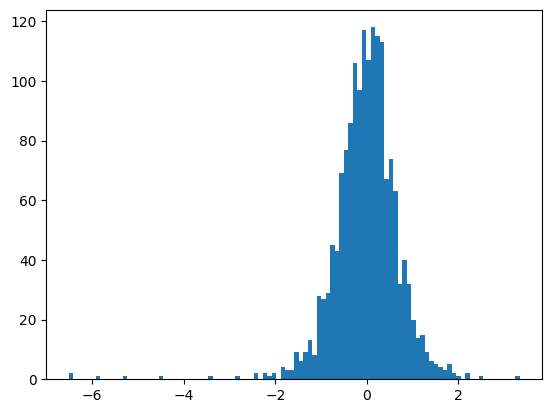

In [777]:
coef_arr = logreg.coef_.transpose()
plt.hist(coef_arr, bins=100)
plt.show()

In [759]:
fnd = pd.DataFrame(logreg.coef_)
fnd.columns = logreg.feature_names_in_
fnd = fnd.transpose()

In [767]:
# фичи не влияющие на предсказания
fnd[fnd[0]==0]

,0
geo_city_Beaver Falls,0.0
geo_city_Brescia,0.0
geo_city_Charlottesville,0.0
geo_city_Guingamp,0.0
geo_city_Herne,0.0


In [778]:
# фичи предсказывающие 1
fnd[fnd[0]>2]

,0
utm_campaign_kwdmElMUPDZaLQdgjcsI,2.163253
utm_campaign_mSVMBvlHFgftJaQAZEdp,2.178604
utm_keyword_opEZzhCrCCxqjKDmOcMK,2.029731
utm_keyword_pucKZkLDtpMDBTobJAJG,3.337961
geo_country_Morocco,2.484132


In [785]:
# фичи предсказывающие 0
fnd[fnd[0]<-2]

,0
utm_campaign_dMIPlIFgKzafYgowsqtp,-2.436285
utm_campaign_out,-5.289183
utm_adcontent_UxrnyMlRBSOhOjytXnMG,-2.208940
utm_adcontent_XKsYZiUFcdkUXQpoLKyS,-2.446107
utm_adcontent_out,-4.525514
utm_adcontent_vIKILzdGQEEbEpgPefxF,-2.257179
utm_keyword_out,-5.896901
utm_keyword_rDKDygeLjEYNPlteLmRH,-2.086834
device_brand_out,-3.386679
device_screen_resolution_out,-6.509360


In [772]:
sessions[sessions.geo_city_Herne==1]

,target,utm_source_0,utm_source_1,utm_medium_0,utm_medium_1,utm_campaign_AqudXfUnmXWSDWVGYaXr,utm_campaign_BAZCuyHZnaPrMGOMrcCQ,utm_campaign_BKeImrJuRDZcHiSSTdzm,utm_campaign_BVKxkCOHKUOvkpbrLMgZ,utm_campaign_BtHktUgMgEVIjKWdCrLZ,...,geo_city_Zarechnyy,geo_city_Zheleznodorozhny,geo_city_Zheleznogorsk,geo_city_Zhukovskiy,geo_city_Zlatoust,geo_city_Zurich,geo_city_Zvenigorod,geo_city_out,geo_city_Тимофеевка,geo_city_Хомутово
882931,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
882932,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [773]:
sessions[sessions.geo_city_Guingamp==1]

,target,utm_source_0,utm_source_1,utm_medium_0,utm_medium_1,utm_campaign_AqudXfUnmXWSDWVGYaXr,utm_campaign_BAZCuyHZnaPrMGOMrcCQ,utm_campaign_BKeImrJuRDZcHiSSTdzm,utm_campaign_BVKxkCOHKUOvkpbrLMgZ,utm_campaign_BtHktUgMgEVIjKWdCrLZ,...,geo_city_Zarechnyy,geo_city_Zheleznodorozhny,geo_city_Zheleznogorsk,geo_city_Zhukovskiy,geo_city_Zlatoust,geo_city_Zurich,geo_city_Zvenigorod,geo_city_out,geo_city_Тимофеевка,geo_city_Хомутово
1031767,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [774]:
sessions[sessions.geo_city_Charlottesville==1]

,target,utm_source_0,utm_source_1,utm_medium_0,utm_medium_1,utm_campaign_AqudXfUnmXWSDWVGYaXr,utm_campaign_BAZCuyHZnaPrMGOMrcCQ,utm_campaign_BKeImrJuRDZcHiSSTdzm,utm_campaign_BVKxkCOHKUOvkpbrLMgZ,utm_campaign_BtHktUgMgEVIjKWdCrLZ,...,geo_city_Zarechnyy,geo_city_Zheleznodorozhny,geo_city_Zheleznogorsk,geo_city_Zhukovskiy,geo_city_Zlatoust,geo_city_Zurich,geo_city_Zvenigorod,geo_city_out,geo_city_Тимофеевка,geo_city_Хомутово
407416,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
407417,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
407418,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [775]:
sessions[sessions.geo_city_Brescia==1]

,target,utm_source_0,utm_source_1,utm_medium_0,utm_medium_1,utm_campaign_AqudXfUnmXWSDWVGYaXr,utm_campaign_BAZCuyHZnaPrMGOMrcCQ,utm_campaign_BKeImrJuRDZcHiSSTdzm,utm_campaign_BVKxkCOHKUOvkpbrLMgZ,utm_campaign_BtHktUgMgEVIjKWdCrLZ,...,geo_city_Zarechnyy,geo_city_Zheleznodorozhny,geo_city_Zheleznogorsk,geo_city_Zhukovskiy,geo_city_Zlatoust,geo_city_Zurich,geo_city_Zvenigorod,geo_city_out,geo_city_Тимофеевка,geo_city_Хомутово
1080698,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [776]:
sessions[sessions['geo_city_Beaver Falls']==1]

,target,utm_source_0,utm_source_1,utm_medium_0,utm_medium_1,utm_campaign_AqudXfUnmXWSDWVGYaXr,utm_campaign_BAZCuyHZnaPrMGOMrcCQ,utm_campaign_BKeImrJuRDZcHiSSTdzm,utm_campaign_BVKxkCOHKUOvkpbrLMgZ,utm_campaign_BtHktUgMgEVIjKWdCrLZ,...,geo_city_Zarechnyy,geo_city_Zheleznodorozhny,geo_city_Zheleznogorsk,geo_city_Zhukovskiy,geo_city_Zlatoust,geo_city_Zurich,geo_city_Zvenigorod,geo_city_out,geo_city_Тимофеевка,geo_city_Хомутово
1125324,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [781]:
sessions[sessions['geo_country_Morocco']==1].target.value_counts()

target
0    115
1     22
Name: count, dtype: int64

In [782]:
sessions[sessions['utm_keyword_pucKZkLDtpMDBTobJAJG']==1].target.value_counts()


target
0    1137
1      44
Name: count, dtype: int64

In [784]:
sessions[sessions['utm_keyword_opEZzhCrCCxqjKDmOcMK']==1].target.value_counts()

target
0    419
1     13
Name: count, dtype: int64